## Imports

In [37]:
#import required libraries
#pandas to make and manipulate dataframes
#numpy for the technical analysis
import pandas as pd
import numpy as np
import math
import panel as pn
import tradingview_ta as tv
from tradingview_ta import TA_Handler, Interval, Exchange


pn.extension('plotly')
#import pandas_ta as ta
import hvplot.pandas
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50)

In [31]:
# parameter setup (default values in the original indicator)
#These are the constants to be used for the moving averages and future indicator additions
#ultimately these will be needed for the squeeze and other calculations
length = 20
mult = 2
length_KC = 21
mult_KC = 2

## Input Stock

In [41]:
symbol_tv = TA_Handler(
    symbol="AMD",
    screener="america",
    exchange="NASDAQ",
    interval=Interval.INTERVAL_1_DAY,
    # proxies={'http': 'http://example.com:8080'} # Uncomment to enable proxy (replace the URL).
)
print(symbol_tv.get_analysis().summary)

{'RECOMMENDATION': 'SELL', 'BUY': 7, 'SELL': 10, 'NEUTRAL': 9}


In [ ]:
value 

In [36]:
#With this code you can input any stock and the data for the stock will be pulled from the Yahoo Finance API using yf.Ticker
#The data is pulled for 3 years with a daily timeframe and put into a dataframe called df_stock
value = input("Enter Stock Symbol:")
period = input('enter period of data eg 1y or 2y:')
interval = input('enter candle interval eg 1d, 1wk, 1mo, 1h')
stock = tv.symbol(value)
print(stock.info)
stock_df = stock.history(period=period, interval=interval)
stock_df.index.duplicated().sum()
df_stock = stock_df.loc[~stock_df.index.duplicated(keep='first')]
df_stock.dropna(inplace=True)

Enter Stock Symbol: tsla
enter period of data eg 1y or 2y: 1y
enter candle interval eg 1d, 1wk, 1mo, 1h 1d


AttributeError: module 'tradingview_ta' has no attribute 'symbol'

## Create Candlestick Chart

In [20]:
#import mplfinance to make the candlestick charts.  
import mplfinance as mpf
%matplotlib widget
# Creating dataframe to graph in candle stick mode
ohcl = df_stock[['Open', 'High', 'Close', 'Low']]
ohcl.tail()

,Open,High,Close,Low
Date,,,,
2022-03-15,775.27002,805.570007,801.890015,756.570007
2022-03-16,809.00000,842.000000,840.229980,802.260010
2022-03-17,830.98999,875.000000,871.599976,825.719971
2022-03-18,874.48999,907.849976,905.390015,867.390015
2022-03-21,914.97998,942.849976,921.159973,907.090027


In [24]:
df_stock['tr0'] = abs(df_stock["High"] - df_stock["Low"])
df_stock['tr1'] = abs(df_stock["High"] - df_stock["Close"].shift())
df_stock['tr2'] = abs(df_stock["Low"] - df_stock["Close"].shift())
df_stock['tr'] = df_stock[['tr0', 'tr1', 'tr2']].max(axis=1)
# moving average of the TR or average true range
range_ma = df_stock['tr'].ewm(span=length_KC).mean()

In [25]:
#ADX Calculations
# Average directional index which shows the trend of the stock.  Above 20 means trending and below means sideways movement

plus_dm = df_stock["High"].diff()
minus_dm = df_stock["Low"].diff()
plus_dm[plus_dm < 0] = 0
minus_dm[minus_dm > 0] = 0

#plus_di and minus di show the direction of the trend, if plus_di > minus_di the trend is positive
#if minus_di > plus_di the trend is negative
df_stock['atr'] = df_stock['tr'].ewm(span=14).mean()
df_stock['plus_di'] = 100 * (plus_dm.ewm(alpha = 1/14).mean() / df_stock['atr'])
df_stock['minus_di'] = abs(100 * (minus_dm.ewm(alpha = 1/14).mean() / df_stock['atr']))
dx = (abs(df_stock['plus_di'] - df_stock['minus_di']) / abs(df_stock['plus_di'] + df_stock['minus_di'])) * 100
adx = ((dx.shift(1) * (14 - 1)) + dx) / 14
df_stock['adx'] = adx.ewm(alpha = 1/14).mean() #ADX>20 is trending ADX<20 not trending

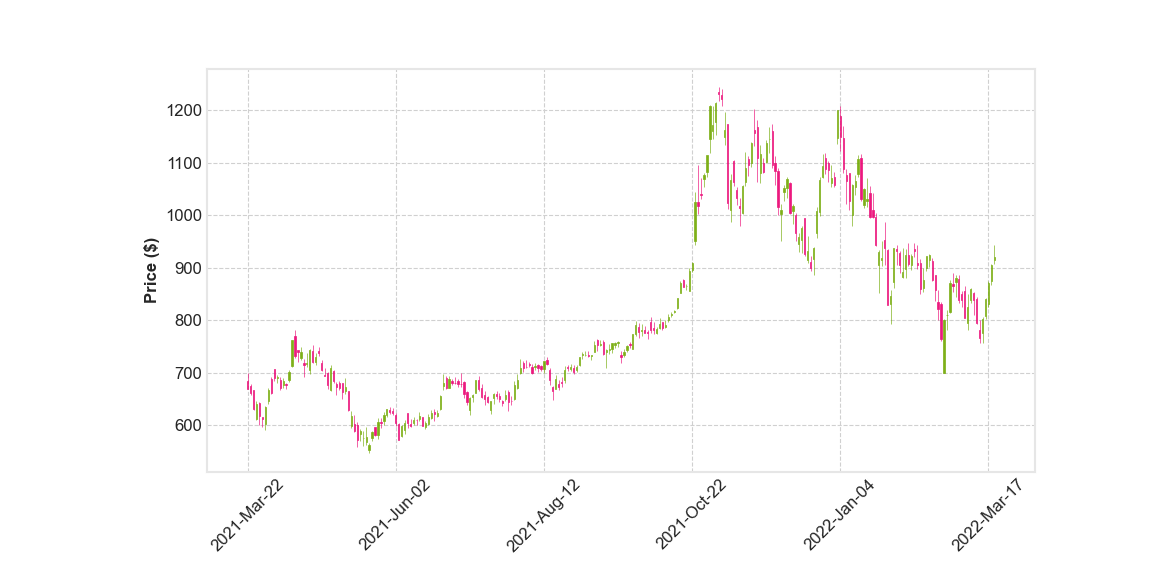

In [28]:
# Adding all the plots including ADX, Stacked moving averages and Squeeze,2 subplots: 1. bars, 2. crosses
# apds = [mpf.make_addplot(df_stock['value'], panel=1, type='bar', color=colors, alpha=0.8, secondary_y=False),
#         mpf.make_addplot([0] * len(df_stock), panel=1, type='scatter', marker='o', markersize=50, color=['gray' if s else 'red' for s in df_stock['squeeze_off']], secondary_y=False),
#         mpf.make_addplot(df_stock[['ADX_trend']], panel=2, color = 'red', secondary_y=False),]

fig, axes = mpf.plot(df_stock, 
              volume_panel = 2,
              figratio=(2,1),
              figscale=1,
              type='candle',
              style='binance',
              ylabel='Price ($)',
              # addplot=apds,  
              returnfig=True)